## Load Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

## Load Data

In [3]:
clickstream_df = pd.read_csv('data/feature_clickstream.csv')

In [5]:
attributes_df = pd.read_csv('data/features_attributes.csv')

In [7]:
financials_df = pd.read_csv('data/features_financials.csv')

In [9]:
loan_df = pd.read_csv('data/lms_loan_daily.csv')

## Data Audit

General Principle
* Decouple raw feature ingestion from model-specific logic.
* Do not inject my own assumptions on preferred imputation strategy e.g. "Unknown"
* Allow downstream users to do their own impute, drop, or encode strategy based on their use case

### Clickstream Table

In [ ]:
clickstream_df.head()

In [ ]:
# All data in integer format except customer id and snapshot date
clickstream_df.info()

In [ ]:
# No missing values
clickstream_df.isnull().sum()

In [ ]:
# Each customer has a snapshot per month
clickstream_df[clickstream_df['Customer_ID']=='CUS_0x1011']

In [ ]:
# Monthly clickstream data, 24 unique months (2023-2024)
clickstream_df.nunique()

In [ ]:
# Have negative values which does not make sense for clickstream data
# which is the no. of page views, clicks, etc
# Distribution looks very similar (same mean, std, min, max, percentiles)
clickstream_df.describe()

In [ ]:
# Plot histogram to confirm distribution
# All normal distribution and around the same

for col in clickstream_df.columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=clickstream_df, x=col, kde=True, bins=30)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

In [11]:
# Clean clickstream data
columns_to_convert = clickstream_df.columns.difference(['Customer_ID', 'snapshot_date'])
clickstream_df[columns_to_convert] = clickstream_df[columns_to_convert].apply(pd.to_numeric, errors='coerce')

In [13]:
for col in columns_to_convert:
    clickstream_df.loc[clickstream_df[col] < 0, col] = 0

In [15]:
clickstream_df.head()

,fe_1,fe_2,fe_3,fe_4,fe_5,fe_6,fe_7,fe_8,fe_9,fe_10,...,fe_13,fe_14,fe_15,fe_16,fe_17,fe_18,fe_19,fe_20,Customer_ID,snapshot_date
0,63,118,80,121,55,193,111,112,0,83,...,0,0,0,114,35,85,0,76,CUS_0x1037,2023-01-01
1,0,182,123,4,0,27,25,0,284,222,...,0,0,200,35,130,94,111,75,CUS_0x1069,2023-01-01
2,0,8,87,166,214,0,215,152,129,139,...,26,86,171,125,0,354,17,302,CUS_0x114a,2023-01-01
3,0,45,200,89,128,54,76,51,61,139,...,172,96,174,163,37,207,180,118,CUS_0x1184,2023-01-01
4,55,120,226,0,253,97,107,68,103,126,...,76,43,183,159,0,104,118,184,CUS_0x1297,2023-01-01


Insight
* All clickstream features only convey the same information on user behaviour
* If we had to use the data, just need to use 1 of the variables

Data processing required for each col (Bronze Table)
* Cast as int
* remove negative values

In terms of feature engineering
* Just use 1 feature coz the distribution of all features is around the same

### Attributes Table

In [ ]:
attributes_df.head()

In [ ]:
# Age is string, which is weird
attributes_df.info()

In [ ]:
# No missing values
attributes_df.isnull().sum()

In [ ]:
attributes_df.nunique()

Name

In [21]:
name_pattern = r"^[A-Za-z][A-Za-z .'-]*[A-Za-z]?$"

attributes_df['is_valid_name'] = attributes_df['Name'].str.match(name_pattern)

invalid_names = attributes_df[attributes_df['is_valid_name'] == 0]

In [23]:
invalid_names['Name'].tolist()

[]

In [25]:
# Clean name function
def clean_name(name):
    if pd.isna(name):
        return name
    cleaned = re.sub(r"[^A-Za-z .'-]", '', name) # remove invalid chars
    cleaned = cleaned.strip() # strip leading and trailing white space
    return cleaned

# Apply the cleaning function
attributes_df['Name'] = attributes_df['Name'].apply(clean_name)

In [27]:
# Verify cleaning changes
attributes_df['is_valid_name'] = attributes_df['Name'].str.match(name_pattern)
invalid_names_post = attributes_df[attributes_df['is_valid_name'] == 0]

In [29]:
invalid_names_post

,Customer_ID,Name,Age,SSN,Occupation,snapshot_date,is_valid_name


In [31]:
# Drop is_valid_name col after cleaning
attributes_df.drop(columns=['is_valid_name'], inplace=True)
attributes_df.head()

,Customer_ID,Name,Age,SSN,Occupation,snapshot_date
0,CUS_0x1000,Alistair Barrf,18,913-74-1218,Lawyer,2023-05-01
1,CUS_0x1009,Arunah,26,063-67-6938,Mechanic,2025-01-01
2,CUS_0x100b,Shirboni,19,#F%$D@*&8,Media_Manager,2024-03-01
3,CUS_0x1011,Schneyerh,44,793-05-8223,Doctor,2023-11-01
4,CUS_0x1013,Cameront,44,930-49-9615,Mechanic,2023-12-01


Age

In [ ]:
# Age data is very dirty
## Underscores after the number
## Age has unreasonable values (above 100+)
## To remove underscores and unreasonable years
attributes_df['Age'].unique()

In [33]:
# Remove non digit chars and convert to numeric
attributes_df['Age'] = attributes_df['Age'].astype(str).str.replace(r'\D', '', regex=True)
attributes_df['Age'] = pd.to_numeric(attributes_df['Age'], errors='coerce')

# Remove invalid ages with np.nan
attributes_df.loc[(attributes_df['Age'] < 0) | (attributes_df['Age'] > 100), 'Age'] = np.nan

In [35]:
# Check distribution after cleaning
print(attributes_df['Age'].describe())

# Removed 319 invalid values
print(attributes_df['Age'].isna().sum())

count    12181.000000
mean        33.619079
std         10.769333
min         14.000000
25%         25.000000
50%         33.000000
75%         42.000000
max         56.000000
Name: Age, dtype: float64
319


Social Security

In [37]:
# The Social Security number is a nine-digit number in the format "AAA-GG-SSSS"
#F%$D@*&8

attributes_df['is_valid_ssn'] = attributes_df['SSN'].str.match(r'^\d{3}-\d{2}-\d{4}$')

invalid_ssns = attributes_df[attributes_df['is_valid_ssn'] == 0]

In [ ]:
invalid_ssns

In [39]:
# Replace invalid SSN with np.nan
attributes_df.loc[(attributes_df['is_valid_ssn'] == False), 'SSN'] = np.nan

In [41]:
# Run check again
attributes_df['is_valid_ssn'] = attributes_df['SSN'].str.match(r'^\d{3}-\d{2}-\d{4}$')
invalid_ssns = attributes_df[attributes_df['is_valid_ssn'] == 0]

In [43]:
# Drop is_valid_ssn col after cleaning
attributes_df.drop(columns=['is_valid_ssn'], inplace=True)
attributes_df.head()

,Customer_ID,Name,Age,SSN,Occupation,snapshot_date
0,CUS_0x1000,Alistair Barrf,18.0,913-74-1218,Lawyer,2023-05-01
1,CUS_0x1009,Arunah,26.0,063-67-6938,Mechanic,2025-01-01
2,CUS_0x100b,Shirboni,19.0,NaN,Media_Manager,2024-03-01
3,CUS_0x1011,Schneyerh,44.0,793-05-8223,Doctor,2023-11-01
4,CUS_0x1013,Cameront,44.0,930-49-9615,Mechanic,2023-12-01


Occupation

In [ ]:
# Unknown occupation with _______
# Media Manager has underscore, need to clean off
attributes_df['Occupation'].unique()

In [45]:
# 7% of users have missing occupation
attributes_df['Occupation'] = attributes_df['Occupation'].replace('_______', np.nan)
attributes_df['Occupation'] = attributes_df['Occupation'].replace('Media_Manager', 'Media Manager')

occupation_counts = attributes_df['Occupation'].value_counts(dropna=False, normalize=True) * 100
occupation_counts = occupation_counts.rename("Percentage").to_frame()
print(occupation_counts)

               Percentage
Occupation               
NaN                 7.040
Lawyer              6.624
Architect           6.360
Engineer            6.344
Accountant          6.328
Scientist           6.312
Teacher             6.256
Mechanic            6.240
Media Manager       6.240
Developer           6.240
Entrepreneur        6.208
Journalist          6.088
Doctor              6.080
Musician            5.928
Manager             5.888
Writer              5.824


In [ ]:
# Each customer has 1 record, which is reasonable (no duplicates)
# Snapshot date probably captures the date the customer created an account
cust_records = attributes_df.groupby('Customer_ID')['snapshot_date'].count()
cust_records.describe()

Data Processing Required for Each Col
* Name: Remove disallowed punctuations and trailing spaces
* Age: Remove non numeric chars and cast as integer, replace invalid ages (<0, >100) as np.nan (2.5% data)
* SSN: Remove data not conforming to SSS format, replace as np.nan
* Occupation: Replace _____ as np.nan (7% data)

Feature Engineering
* Take Age and Occupation as potentially useful features

### Financials Table

In [ ]:
financials_df.head()

In [ ]:
# Annual income should be float
# Num bank accounts has negative value, and weirdly high numbers
# Num credit card has weirdly high numbers
# Interest Rate is in integer, assume in percentage
# Num of Loan has negative value, underscores, and weirdly high numbers
# Type of Loan can split into comma separate values and "and"
# Delay from due date has negative numbers
# Num of Delayed Payment has negative value, underscores, and weirdly high numbers
# Changed credit limit has underscores
# Num_Credit_Inquiries has weirdly high numbers
# Credit_Mix has _ (unknown)
# Outstanding_Debt has underscores
# Credit_History_Age change from text to a float in years
# Payment_of_Min_Amount has "NM" (Not mentioned)
# Total_EMI_per_month means Equated Mthly Installments. Total amount a person pays for all their loans mthly (measures financial burden)
# Amount_invested_monthly has some underscores _10000_
# Payment_Behaviour consists of 2 features (Spent, Value of Payment). Some dirty data !@9#%8
# Monthly_Balance has 1 non numeric value __-333333333333333333333333333__
# snapshot_date seems like no issue

financials_df.info()

In [ ]:
non_numeric_mask = pd.to_numeric(financials_df['Monthly_Balance'], errors='coerce').isna()

# Filter the non-numeric rows
non_numeric_values = financials_df.loc[non_numeric_mask, 'Monthly_Balance']

print(non_numeric_values.unique()) 

In [ ]:
# Some missing values for Type_of_Loan
financials_df.isnull().sum()

In [ ]:
type_of_loan_missing = financials_df[financials_df['Type_of_Loan'].isnull()]

In [ ]:
# When checking, some of these missing entries is because the customer doesnt have loans at all
# Some of it is valid
type_of_loan_missing['Num_of_Loan'].unique()

In [47]:
# Clean currency related columns to 3 dp
cols_decimal3 = [
    'Annual_Income',
    'Monthly_Inhand_Salary',
    'Outstanding_Debt',
    'Total_EMI_per_month',
    'Amount_invested_monthly',
    'Monthly_Balance'
]

# Remove non-digit characters (excluding the decimal point)
for col in cols_decimal3:
    financials_df[col] = (
        financials_df[col]
        .astype(str)
        .str.replace(r'[^\d.]', '', regex=True)  # Keep only digits and dec pt.
    )

# Convert to float and round to 3 decimal places
for col in cols_decimal3:
    financials_df[col] = (
        pd.to_numeric(financials_df[col], errors='coerce')  # convert to float, invalids to NaN
        .round(3)                                           # round to 3 decimal places
    )

# Replace negative values to nan
for col in cols_decimal3:
    financials_df.loc[financials_df[col] < 0, col] = np.nan

In [49]:
# Clean columns related to integers
cols_integer = [
    'Num_Bank_Accounts',
    'Num_Credit_Card',
    'Num_of_Loan',
    'Delay_from_due_date',
    'Num_of_Delayed_Payment',
    'Num_Credit_Inquiries',
    'Interest_Rate'
]

for col in cols_integer:
    financials_df[col] = (
        financials_df[col]
        .astype(str)
        .str.replace(r'[^\d]', '', regex=True)  # Remove all except digits
    )

for col in cols_integer:
    financials_df[col] = pd.to_numeric(financials_df[col], errors='coerce')

for col in cols_integer:
    financials_df.loc[financials_df[col] < 0, col] = np.nan

In [51]:
# Convert Credit_History_Age to integer

def convert_to_months(time_str):
    match = re.match(r'(\d+) Years and (\d+) Months', time_str)
    
    if match:
        years = int(match.group(1))  # Extract years
        months = int(match.group(2))  # Extract months
        total_months = (years * 12) + months
        return total_months
    else:
        return np.nan  # Return NaN if the format is incorrect

# Apply the function to the column
financials_df['Credit_History_Age'] = financials_df['Credit_History_Age'].apply(convert_to_months)

In [53]:
# Clean currency related columns to float
cols_float = [
    'Changed_Credit_Limit',
    'Credit_Utilization_Ratio'
]

# Remove non-digit characters (excluding the decimal point)
for col in cols_float:
    financials_df[col] = (
        financials_df[col]
        .astype(str)
        .str.replace(r'[^\d.]', '', regex=True)  # Keep only digits and dec pt.
    )

# Convert to float, invalid values to nan
for col in cols_float:
    financials_df[col] = pd.to_numeric(financials_df[col], errors='coerce')

# Only check for negatives for Credit_Utilization_Ratio
if 'Credit_Utilization_Ratio' in cols_float:
    financials_df.loc[financials_df['Credit_Utilization_Ratio'] < 0, 'Credit_Utilization_Ratio'] = np.nan

Outliers Treatment
* Windsorize unreasonably high values with the max reasonable number (checked from EDA) so as not to lose the data

In [55]:
outlier_caps = {
    'Num_Bank_Accounts': 10,
    'Num_Credit_Card': 10,
    'Interest_Rate': 34,
    'Num_of_Loan': 9,
    'Num_of_Delayed_Payment': 47,
    'Num_Credit_Inquiries': 26
}

# Apply the capping
for col, cap in outlier_caps.items():
    financials_df[col] = financials_df[col].clip(upper=cap)

Categorical Variables Treatment

In [57]:
# Credit_Mix 3 enums (Bad, Good, Standard). 
# Standardize _ (unknown) to be np.nan

valid_cm_enums = ['Bad', 'Good', 'Standard']
financials_df['Credit_Mix'] = financials_df['Credit_Mix'].where(financials_df['Credit_Mix'].isin(valid_cm_enums), np.nan)

# Define the mapping from string to integer
credit_mix_mapping = {
    'Bad': 0,
    'Standard': 1,
    'Good': 2
}

# Encode credit mix with the mapping
financials_df['Credit_Mix'] = financials_df['Credit_Mix'].map(credit_mix_mapping)

In [59]:
# Payment_of_Min_Amount has 2 enums (Yes, No)
# Remove NM (Not mentioned), as good as dont know.
# Check all values conform to these enums

valid_pm_enums = ['Yes', 'No']
financials_df['Payment_of_Min_Amount'] = financials_df['Payment_of_Min_Amount'].where(financials_df['Payment_of_Min_Amount'].isin(valid_pm_enums), np.nan)

# Encode to boolean
financials_df['Payment_of_Min_Amount'] = financials_df['Payment_of_Min_Amount'].map({
    'Yes': True,
    'No': False
})

In [61]:
# Payment_Behaviour has 6 enums. 
# Check all values conform to these enums. Remove dirty data !@9#%8

valid_pb_enums = [
    'High_spent_Small_value_payments',
    'High_spent_Medium_value_payments',
    'High_spent_Large_value_payments',
    'Low_spent_Small_value_payments',
    'Low_spent_Medium_value_payments',
    'Low_spent_Large_value_payments'
]
financials_df['Payment_Behaviour'] = financials_df['Payment_Behaviour'].where(financials_df['Payment_Behaviour'].isin(valid_pb_enums), np.nan)

# Encode string into arbitrary number mapping as categorical
pb_mapping = {
    'Low_spent_Small_value_payments': 0,
    'Low_spent_Medium_value_payments': 1,
    'Low_spent_Large_value_payments': 2,
    'High_spent_Small_value_payments': 3,
    'High_spent_Medium_value_payments': 4,
    'High_spent_Large_value_payments': 5
}

financials_df['Payment_Behaviour'] = financials_df['Payment_Behaviour'].map(pb_mapping)

Data Processing Required for Each Col
* Clean respective cols to their data types (e.g. decimal 3dp, integers, float)
* Remove invalid non digit chars and unknown values
* For categorical data, ensure values are in enums

Feature Engineering
* Take Age and Occupation as potentially useful features

### Loans Table

In [ ]:
loan_df.head()

In [ ]:
# Data types look correct
loan_df.info()

In [ ]:
# No missing values
loan_df.isnull().sum()

In [ ]:
# In this company the loan that is being approved is for 1 type: tenure 10 months, loan amount 10k
loan_df.describe()

In [ ]:
# The loans take place from any 10 month period from 2023 - 2025
loan_df['snapshot_date'] = pd.to_datetime(loan_df['snapshot_date'], errors='coerce')

# Step 2: Get min and max
min_date = loan_df['snapshot_date'].min()
max_date = loan_df['snapshot_date'].max()
print(min_date, max_date)

Insights
* Clean, no extra processing required

## Create Labels

Note data availability
* Clickstream date range (Jan 2023 - Dec 2024)
* Attributes date range (Jan 2023 - Jan 2025)
* Financials date range (Jan 2023 - Jan 2025)
* Loans date range (Jan 2023 - Nov 2025)

Since most feature data is only up till Dec 2024, this means that I can only train on people who have already completed the loan before Dec 2024, so I know for sure who defaulted

In [63]:
# Add new features days past due
from dateutil.relativedelta import relativedelta

# Ensure dates are datetime
loan_df['snapshot_date'] = pd.to_datetime(loan_df['snapshot_date'], errors='coerce')

# Step 1: Calculate installments missed
loan_df['installments_missed'] = np.ceil(loan_df['overdue_amt'] / loan_df['due_amt'])
loan_df['installments_missed'] = loan_df['installments_missed'].fillna(0).astype(int)

# Step 2: Calculate first missed date
def calculate_first_missed(row):
    if row['installments_missed'] > 0:
        return row['snapshot_date'] - relativedelta(months=row['installments_missed'])
    else:
        return pd.NaT

loan_df['first_missed_date'] = loan_df.apply(calculate_first_missed, axis=1)

# Step 3: Calculate DPD (days past due)
loan_df['dpd'] = np.where(
    loan_df['overdue_amt'] > 0,
    (loan_df['snapshot_date'] - loan_df['first_missed_date']).dt.days,
    0
)
loan_df['dpd'] = loan_df['dpd'].fillna(0).astype(int)

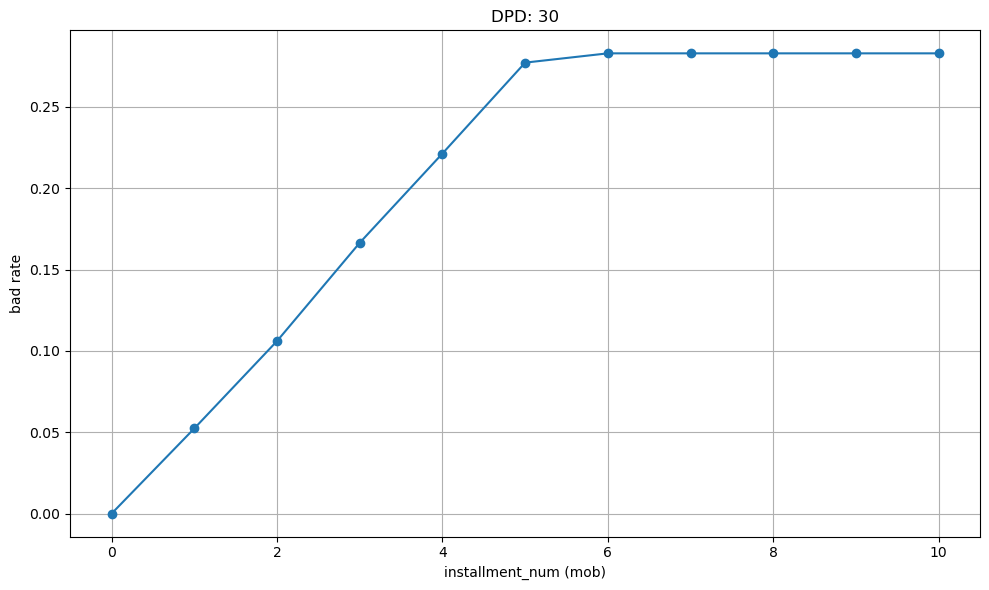

In [65]:
from datetime import datetime

# set dpd label definition
dpd = 30

# filter only completed loans
loan_df['loan_start_date'] = pd.to_datetime(loan_df['loan_start_date'], errors='coerce') # convert to datetime format first
loan_df = loan_df[loan_df['loan_start_date'] < datetime.strptime("2024-01-01", "%Y-%m-%d")]

# create dpd flag if more than dpd
loan_df['dpd_flag'] = (loan_df['dpd'] >= dpd).astype(int)

# Group by col_A and count occurrences in col_B
grouped = loan_df.groupby('installment_num')['dpd_flag'].mean().sort_index()

# Plotting
grouped.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('DPD: ' + str(dpd))
plt.xlabel('installment_num (mob)')
plt.ylabel('bad rate')
plt.grid(True)
plt.tight_layout()
plt.show()

Summary of logic
* The label is created by only checking the customer's loan situation at installment 6 (installment_num == 6)
* This is done by subsetting the data to only include rows at installment number 6
* The dpd at installment 6 is checked, and if >= 30 days, label customer as defaulter.

Implications
* Even if the customer was paid back on time for months 7 and onward, he’s still labeled as 1 if he was overdue 30+ days as of month 6
* A customer who missed an installment earlier (say in month 2), but fully caught up before or by month 6, and is not overdue 30+ days at month 6 → will be labeled 0

In [67]:
# Output label_df table
mob = 6

label_df = loan_df[loan_df['installment_num'] == mob]
label_df = label_df.rename(columns={'dpd_flag': 'label'})

label_df['label_def'] = str(dpd) + 'dpd_' + str(mob) + 'mob'

# Select necessary columns
label_df = label_df[['loan_id', 'Customer_ID', 'loan_start_date', 'label', 'label_def', 'snapshot_date']]
label_df

,loan_id,Customer_ID,loan_start_date,label,label_def,snapshot_date
6,CUS_0x1000_2023_05_01,CUS_0x1000,2023-05-01,1,30dpd_6mob,2023-11-01
39,CUS_0x1011_2023_11_01,CUS_0x1011,2023-11-01,0,30dpd_6mob,2024-05-01
50,CUS_0x1013_2023_12_01,CUS_0x1013,2023-12-01,0,30dpd_6mob,2024-06-01
61,CUS_0x1015_2023_08_01,CUS_0x1015,2023-08-01,0,30dpd_6mob,2024-02-01
72,CUS_0x1018_2023_11_01,CUS_0x1018,2023-11-01,1,30dpd_6mob,2024-05-01
...,...,...,...,...,...,...
137352,CUS_0xfcc_2023_02_01,CUS_0xfcc,2023-02-01,0,30dpd_6mob,2023-08-01
137385,CUS_0xfdd_2023_10_01,CUS_0xfdd,2023-10-01,0,30dpd_6mob,2024-04-01
137418,CUS_0xfe4_2023_09_01,CUS_0xfe4,2023-09-01,0,30dpd_6mob,2024-03-01
137429,CUS_0xfe5_2023_06_01,CUS_0xfe5,2023-06-01,0,30dpd_6mob,2023-12-01


C:\Users\TYY\AppData\Local\Temp\ipykernel_18828\4164867911.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_default_rate = attr_label_df.groupby('age_group')['label'].mean()


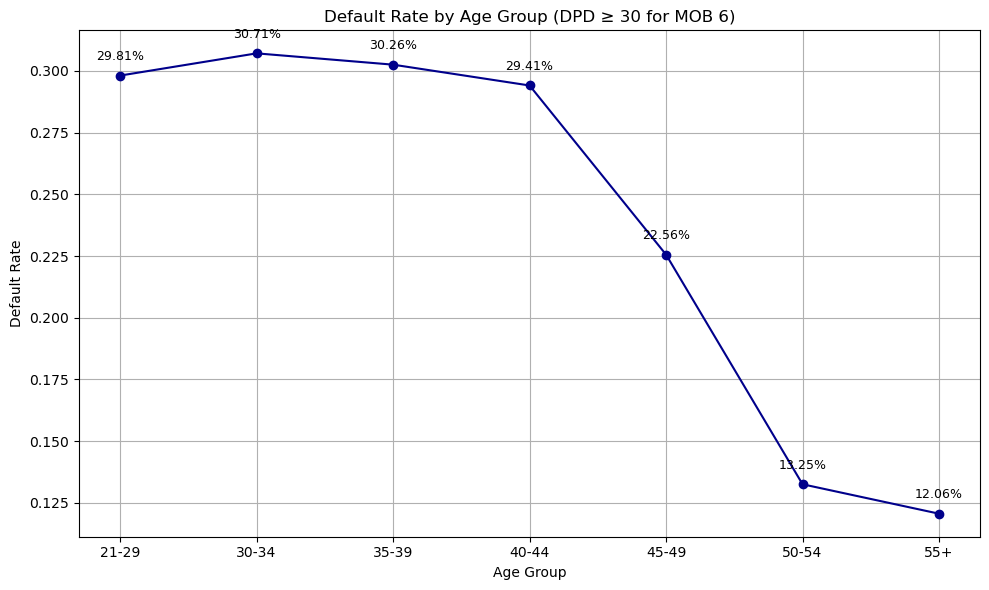

In [71]:
# Make sure snapshot_date in attributes_df is in datetime format
attributes_df['snapshot_date'] = pd.to_datetime(attributes_df['snapshot_date'], errors='coerce')

# Merge on Customer_ID and snapshot_date
attr_label_df = pd.merge(
    label_df,
    attributes_df[['Customer_ID', 'Age']],
    on=['Customer_ID'],
    how='left'
)

# Drop rows with missing Age
attr_label_df = attr_label_df.dropna(subset=['Age'])

# Define age bins and labels
bins = [20, 29, 34, 39, 44, 49, 54, np.inf]
labels = ['21-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55+']
attr_label_df['age_group'] = pd.cut(attr_label_df['Age'], bins=bins, labels=labels, right=True)

# Compute default rate by age group
age_group_default_rate = attr_label_df.groupby('age_group')['label'].mean()

# Line plot
plt.figure(figsize=(10, 6))
plt.plot(age_group_default_rate.index, age_group_default_rate.values, marker='o', linestyle='-', color='darkblue')

# Add data labels
for i, (x, y) in enumerate(zip(age_group_default_rate.index, age_group_default_rate.values)):
    plt.text(x, y + 0.005, f"{y:.2%}", ha='center', va='bottom', fontsize=9)

# Titles and labels
plt.title(f'Default Rate by Age Group (DPD ≥ {dpd} for MOB 6)')
plt.xlabel('Age Group')
plt.ylabel('Default Rate')
plt.grid(True)
plt.tight_layout()
plt.show()

## Exploratory Data Analysis

### Prepare Data

In [73]:
# Pick a time to do this analysis. Assume it's Jun 2024 now
snapshot_date_analysis = "2024-06-01"

# Get customers who defaulted in June
label_june_df = label_df[label_df['snapshot_date'] == snapshot_date_analysis]
label_june_df

,loan_id,Customer_ID,loan_start_date,label,label_def,snapshot_date
50,CUS_0x1013_2023_12_01,CUS_0x1013,2023-12-01,0,30dpd_6mob,2024-06-01
193,CUS_0x104a_2023_12_01,CUS_0x104a,2023-12-01,0,30dpd_6mob,2024-06-01
281,CUS_0x1063_2023_12_01,CUS_0x1063,2023-12-01,0,30dpd_6mob,2024-06-01
512,CUS_0x10d7_2023_12_01,CUS_0x10d7,2023-12-01,1,30dpd_6mob,2024-06-01
600,CUS_0x10fd_2023_12_01,CUS_0x10fd,2023-12-01,1,30dpd_6mob,2024-06-01
...,...,...,...,...,...,...
136032,CUS_0xde7_2023_12_01,CUS_0xde7,2023-12-01,0,30dpd_6mob,2024-06-01
136263,CUS_0xe32_2023_12_01,CUS_0xe32,2023-12-01,0,30dpd_6mob,2024-06-01
136318,CUS_0xe42_2023_12_01,CUS_0xe42,2023-12-01,1,30dpd_6mob,2024-06-01
136758,CUS_0xedf_2023_12_01,CUS_0xedf,2023-12-01,1,30dpd_6mob,2024-06-01


In [75]:
# Filter features up to May 2024
# For clickstream data, filter up to mob months before loan default
from pandas.tseries.offsets import DateOffset
from datetime import timedelta

# Pick relevant columns based on domain knowledge
clickstream_features = ['Customer_ID', 'snapshot_date', 'fe_1']
attributes_features = ['Customer_ID', 'snapshot_date', 'Age', 'Occupation']
financials_features = [
    'Customer_ID', 'snapshot_date', 'Annual_Income', 'Monthly_Inhand_Salary',
    'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
    'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
    'Credit_Mix', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age',
    'Total_EMI_per_month', 'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance'
]

start_date = (pd.to_datetime(snapshot_date_analysis) - DateOffset(months=mob)).strftime("%Y-%m-%d")

# Subset each DataFrame using relevant cols
clickstream_df_subset = clickstream_df[clickstream_features]
clickstream_df_subset = clickstream_df_subset[
    (clickstream_df_subset['snapshot_date'] < snapshot_date_analysis) &
    (clickstream_df_subset['snapshot_date'] >= start_date)
]

attributes_df_subset = attributes_df[attributes_features]
attributes_df_subset = attributes_df_subset[attributes_df_subset['snapshot_date'] < snapshot_date_analysis]

financials_df_subset = financials_df[financials_features]
financials_df_subset = financials_df_subset[financials_df_subset['snapshot_date'] < snapshot_date_analysis]

### Pick a random customer to see what kind of data available

In [77]:
# This data is month on month, even when the customer hasnt applied for the loan yet
# Probably describes what he is doing on the app
# It would only be relevant to see the clickstream behavior from the start of the loan period to detect any signs of inactivity leading up to the loan default
clickstream_df_subset[clickstream_df_subset['Customer_ID'] == 'CUS_0x944e']

,Customer_ID,snapshot_date,fe_1
105150,CUS_0x944e,2023-12-01,9
114124,CUS_0x944e,2024-01-01,8
123098,CUS_0x944e,2024-02-01,0
132072,CUS_0x944e,2024-03-01,156
141046,CUS_0x944e,2024-04-01,114
150020,CUS_0x944e,2024-05-01,0


In [79]:
# This is the data captured upon loan application (assumption)
attributes_df_subset[attributes_df_subset['Customer_ID'] == 'CUS_0x944e']

,Customer_ID,snapshot_date,Age,Occupation
8845,CUS_0x944e,2023-10-01,24.0,Architect


In [81]:
# This is the data captured upon loan application (assumption)
financials_df_subset[financials_df_subset['Customer_ID'] == 'CUS_0x944e']

,Customer_ID,snapshot_date,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
8845,CUS_0x944e,2023-10-01,11834.645,688.22,5.0,7.0,10.0,2.0,27.0,13.0,15.62,26.0,1.0,1095.9,37.728638,166,11.09,10000.0,1.0,299.234


### Merge Label with Attribute and Financials Data

In [83]:
# 3. Merge data except clickstream into 1 table
merged_df = label_june_df.copy()

# Merge with attributes
merged_df = pd.merge(merged_df, attributes_df_subset, on='Customer_ID', how='left')

# Merge with financials
merged_df = pd.merge(merged_df, financials_df_subset, on='Customer_ID', how='left')

# 4. Result: a wide table of features + label
print(f"Merged shape: {merged_df.shape}")

Merged shape: (489, 28)


In [85]:
merged_df.columns

Index(['loan_id', 'Customer_ID', 'loan_start_date', 'label', 'label_def',
       'snapshot_date_x', 'snapshot_date_y', 'Age', 'Occupation',
       'snapshot_date', 'Annual_Income', 'Monthly_Inhand_Salary',
       'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance'],
      dtype='object')

In [87]:
merged_df = merged_df.drop(columns=['loan_start_date', 'snapshot_date_x', 'snapshot_date_y', 'snapshot_date', 'label_def'])

In [89]:
merged_df.columns

Index(['loan_id', 'Customer_ID', 'label', 'Age', 'Occupation', 'Annual_Income',
       'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
       'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance'],
      dtype='object')

### EDA

In [91]:
categorical_cols = ['Occupation', 'Credit_Mix', 'Payment_Behaviour']

In [93]:
numeric_cols = [
    'Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate',
    'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
    'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month', 'Monthly_Balance', 
    'label'
]

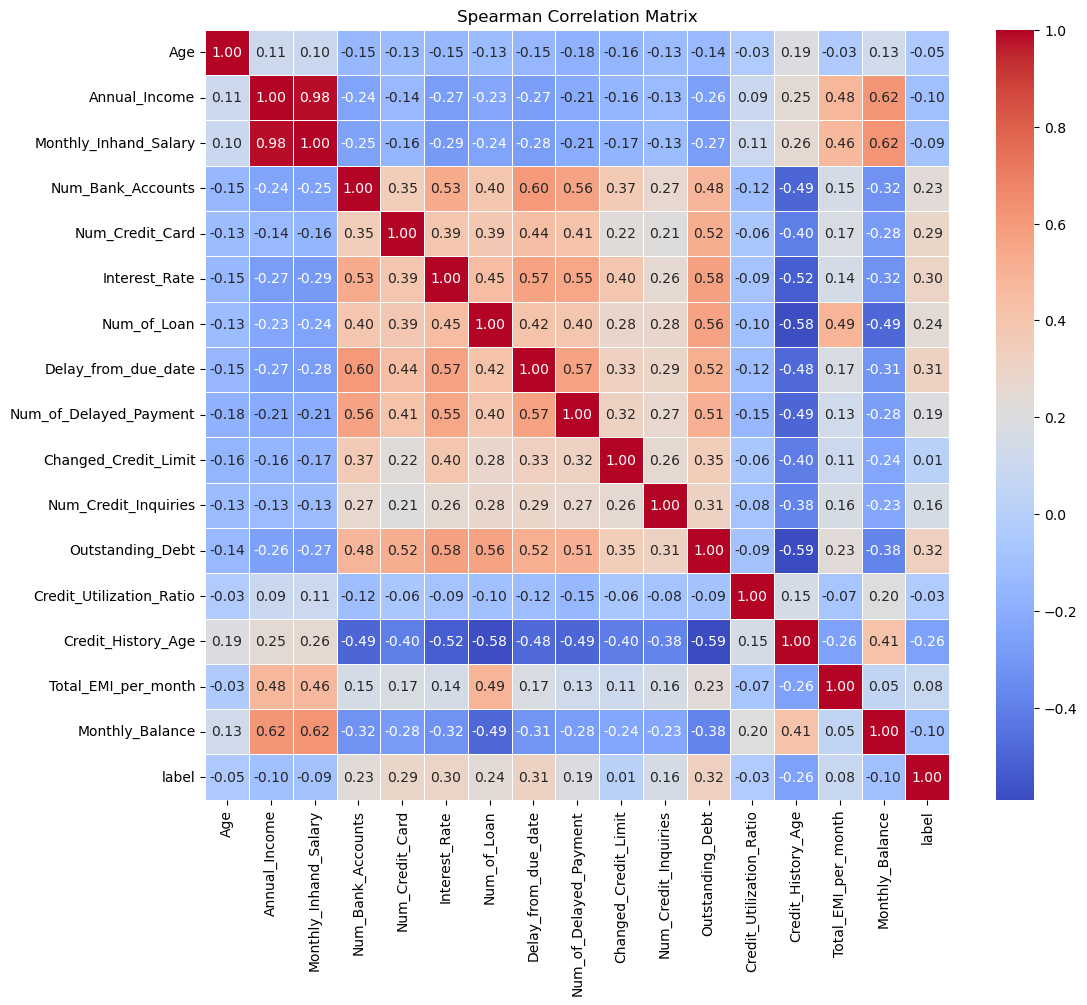

In [95]:
# Calculate Spearman correlation
corr_matrix = merged_df[numeric_cols].corr(method='spearman')

# Visualize the correlation matrix with a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Spearman Correlation Matrix')
plt.show()

# Positive correlation
## Num_Bank_Accounts
## Num_Credit_Card
## Interest_Rate
## Num_of_Loan
## Delay_from_due_date
## Num_of_Delayed_Payment
## Outstanding_Debt
## Credit_History_Age

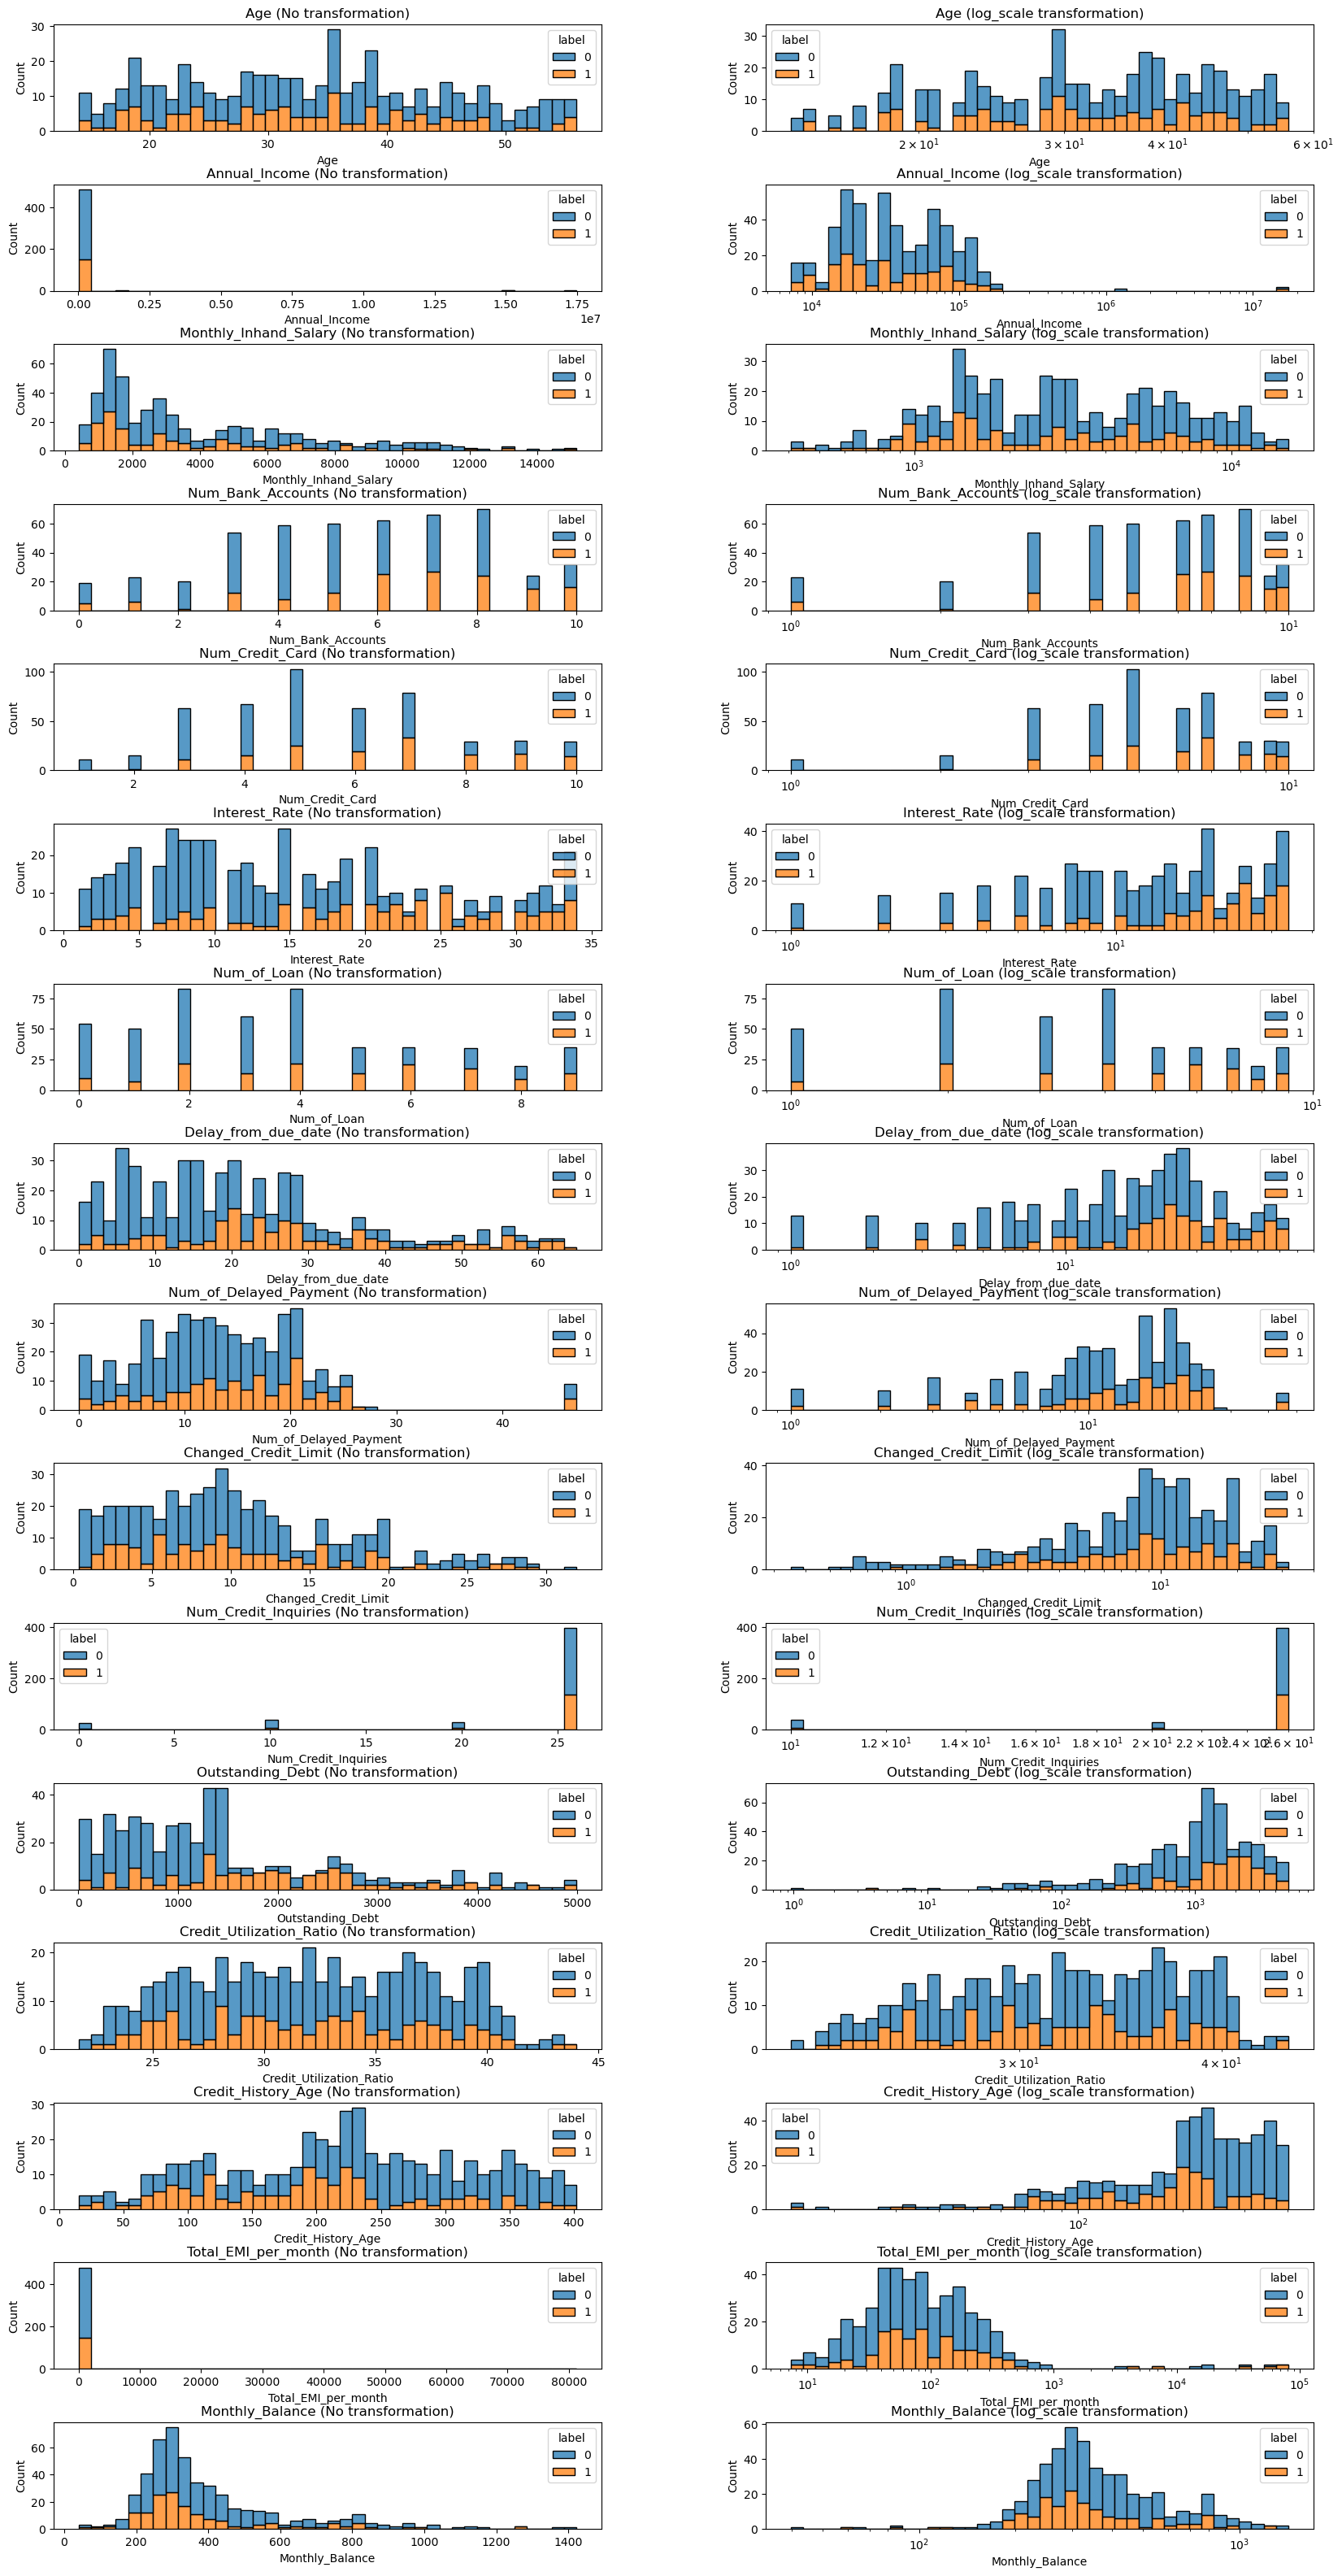

In [97]:
# Explore distributions of numerical features, color coded by target 0 / 1
numeric_cols = [
    'Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate',
    'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
    'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month', 'Monthly_Balance'
]

plt.figure(figsize=(20, 40))

for i, col in enumerate(numeric_cols):
    plt.subplot(len(numeric_cols), 2, 2 * i + 1)  # 2*index + 1 for the first plot
    sns.histplot(data=merged_df, x=col, hue='label', bins=40, log_scale=False, multiple='stack')
    plt.title(f'{col} (No transformation)')

    plt.subplot(len(numeric_cols), 2, 2 * i + 2)  # 2*index + 2 for the second plot
    sns.histplot(data=merged_df, x=col, hue='label', bins=40, log_scale=True, multiple='stack')
    plt.title(f'{col} (log_scale transformation)')

plt.subplots_adjust(hspace=0.5, wspace=0.3)  # Increase vertical and horizontal space
plt.show()

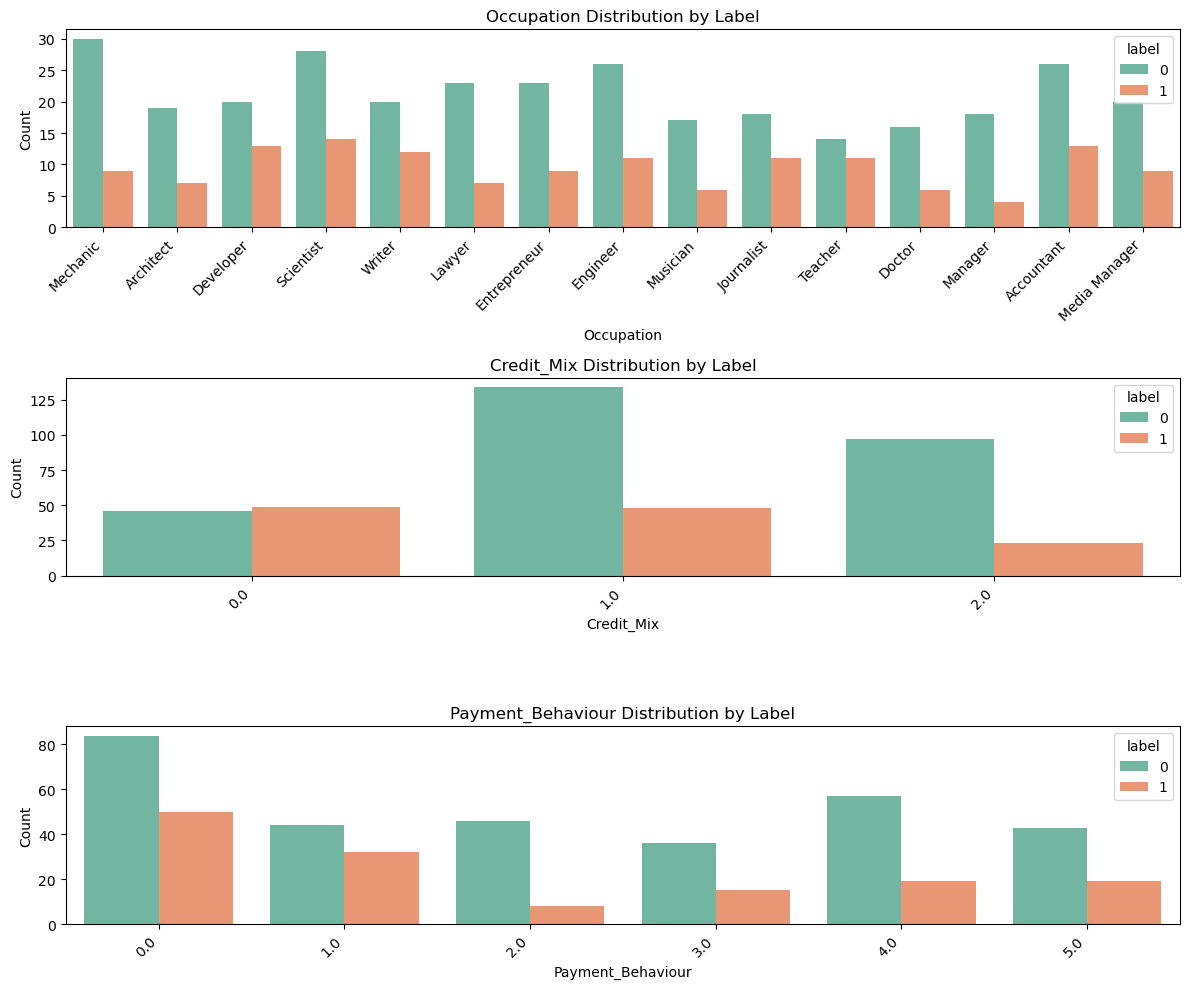

In [99]:
# For categorical cols, seems only Credit_Mix has some correlation to the label

plt.figure(figsize=(12, 10))

for i, col in enumerate(categorical_cols):
    plt.subplot(len(categorical_cols), 1, i + 1)
    sns.countplot(data=merged_df, x=col, hue='label', palette='Set2')
    plt.title(f'{col} Distribution by Label')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

### Merge Label with Clickstream Data

In [101]:
# Pivot clickstream data 
snapshot_date_analysis_format = pd.to_datetime(snapshot_date_analysis)
clickstream_df_subset['snapshot_date'] = pd.to_datetime(clickstream_df_subset['snapshot_date'])

clickstream_df_subset['num_mth_before'] = (
    (snapshot_date_analysis_format.year - clickstream_df_subset['snapshot_date'].dt.year) * 12 +
    (snapshot_date_analysis_format.month - clickstream_df_subset['snapshot_date'].dt.month)
)
pivot = clickstream_df_subset.pivot(index='Customer_ID', columns='num_mth_before', values='fe_1')
pivot.columns = [f'click_{i}m' for i in pivot.columns]
pivot.reset_index(inplace=True)
pivot

,Customer_ID,click_1m,click_2m,click_3m,click_4m,click_5m,click_6m
0,CUS_0x1000,108,65,115,0,224,172
1,CUS_0x100b,122,212,210,38,66,92
2,CUS_0x1011,49,0,161,43,1,94
3,CUS_0x1013,147,0,0,0,181,61
4,CUS_0x1015,122,251,170,0,242,22
...,...,...,...,...,...,...,...
8969,CUS_0xfe5,0,52,33,58,0,117
8970,CUS_0xfea,78,124,157,100,47,69
8971,CUS_0xff3,161,39,162,0,61,171
8972,CUS_0xffc,231,0,96,229,126,228


In [103]:
# Merge with label
merged_df_clk = label_june_df.copy()

# Merge with clickstream pivot
merged_df_clk = pd.merge(merged_df_clk, pivot, on='Customer_ID', how='left')

# 4. Result: a wide table of features + label
print(f"Merged shape: {merged_df_clk.shape}")

merged_df_clk

Merged shape: (489, 12)


,loan_id,Customer_ID,loan_start_date,label,label_def,snapshot_date,click_1m,click_2m,click_3m,click_4m,click_5m,click_6m
0,CUS_0x1013_2023_12_01,CUS_0x1013,2023-12-01,0,30dpd_6mob,2024-06-01,147,0,0,0,181,61
1,CUS_0x104a_2023_12_01,CUS_0x104a,2023-12-01,0,30dpd_6mob,2024-06-01,0,0,5,72,88,27
2,CUS_0x1063_2023_12_01,CUS_0x1063,2023-12-01,0,30dpd_6mob,2024-06-01,193,43,21,155,190,0
3,CUS_0x10d7_2023_12_01,CUS_0x10d7,2023-12-01,1,30dpd_6mob,2024-06-01,53,236,87,183,0,61
4,CUS_0x10fd_2023_12_01,CUS_0x10fd,2023-12-01,1,30dpd_6mob,2024-06-01,239,156,89,150,118,150
...,...,...,...,...,...,...,...,...,...,...,...,...
484,CUS_0xde7_2023_12_01,CUS_0xde7,2023-12-01,0,30dpd_6mob,2024-06-01,116,246,120,91,247,29
485,CUS_0xe32_2023_12_01,CUS_0xe32,2023-12-01,0,30dpd_6mob,2024-06-01,42,98,0,0,189,0
486,CUS_0xe42_2023_12_01,CUS_0xe42,2023-12-01,1,30dpd_6mob,2024-06-01,124,22,0,78,78,0
487,CUS_0xedf_2023_12_01,CUS_0xedf,2023-12-01,1,30dpd_6mob,2024-06-01,44,0,102,60,162,129


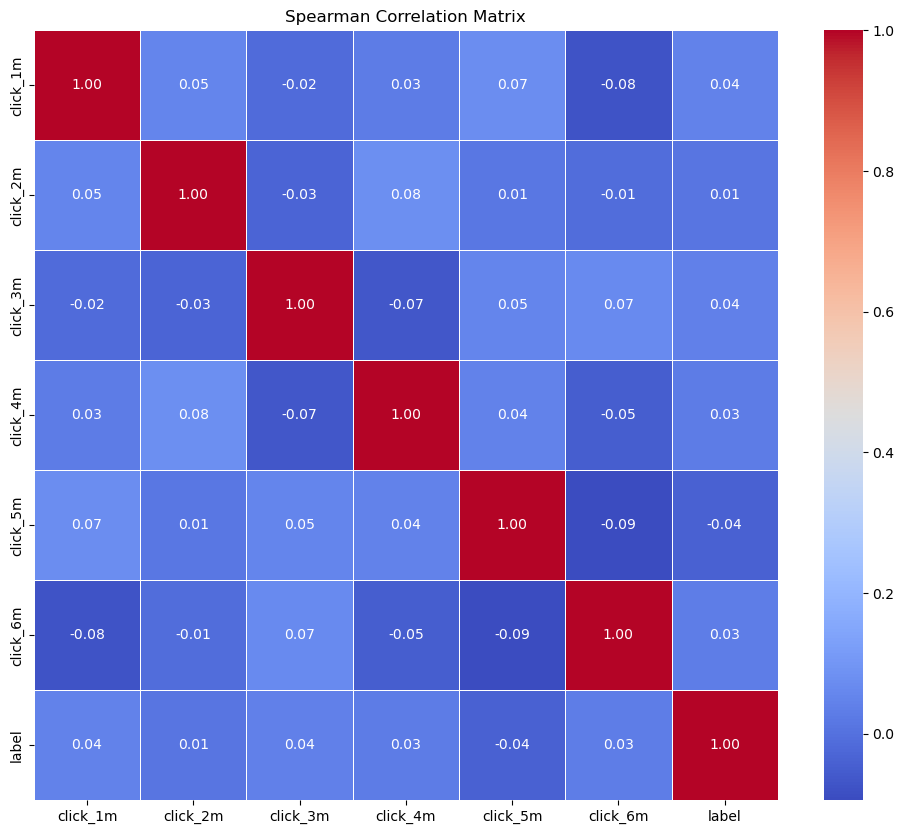

In [105]:
# Calculate Spearman correlation
corr_matrix = merged_df_clk[['click_1m', 'click_2m', 'click_3m', 'click_4m', 'click_5m', 'click_6m', 'label']].corr(method='spearman')

# Visualize the correlation matrix with a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Spearman Correlation Matrix')
plt.show()

# No correlation with the label, not useful

## Feature Engineering

### Merged Table

In [107]:
merged_df['Num_Fin_Pdts'] = merged_df['Num_Bank_Accounts'] + merged_df['Num_Credit_Card'] + merged_df['Num_of_Loan']

In [109]:
merged_df['Loans_per_Credit_Item'] = merged_df['Num_of_Loan'] / (merged_df['Num_Bank_Accounts'] + merged_df['Num_Credit_Card'] + 1)

In [111]:
merged_df['Debt_to_Salary'] = merged_df['Outstanding_Debt'] / (merged_df['Monthly_Inhand_Salary'] + 1)

In [113]:
merged_df['EMI_to_Salary'] = merged_df['Total_EMI_per_month'] / (merged_df['Monthly_Inhand_Salary'] + 1)

In [115]:
merged_df['Repayment_Ability'] = merged_df['Monthly_Inhand_Salary'] - merged_df['Total_EMI_per_month']

In [117]:
merged_df['Loan_Extent'] = merged_df['Delay_from_due_date'] * merged_df['Num_of_Loan']

## Model Training

In [119]:
merged_df.columns

Index(['loan_id', 'Customer_ID', 'label', 'Age', 'Occupation', 'Annual_Income',
       'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
       'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Num_Fin_Pdts', 'Loans_per_Credit_Item', 'Debt_to_Salary',
       'EMI_to_Salary', 'Repayment_Ability', 'Loan_Extent'],
      dtype='object')

In [121]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler
import lightgbm as lgb

In [123]:
# Drop categorical and ID ones
# Drop those that are low in SHAP summary plot
drop_cols = [
    'loan_id', 'Customer_ID', 'label', 'Age', 'Occupation',
    'Num_Credit_Inquiries', 'Repayment_Ability', 'Num_of_Loan'
]

In [125]:
# Separate features and target, extract features to use
y = merged_df['label']
X = merged_df.drop(columns=drop_cols)

In [127]:
# Split data into training and test sets using stratified sampling to handle imbalanced classes
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    shuffle=True, 
    stratify=y
)

In [129]:
print('X_train', X_train.shape[0])
print('X_test', X_test.shape[0])
print('y_train', y_train.shape[0], round(y_train.mean(),2))
print('y_test', y_test.shape[0], round(y_test.mean(),2))

X_train 391
X_test 98
y_train 391 0.31
y_test 98 0.31


In [131]:
# Initialize LightGBM model with default hyperparameters
model = lgb.LGBMClassifier(objective='binary', boosting_type='gbdt', n_jobs=-1, early_stopping_rounds=10)

# Set up Stratified K-Fold cross-validation
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Lists to store results
roc_auc_scores = []

# Cross-validation
for train_index, val_index in kf.split(X_train, y_train):
    # Split data into train and validation sets
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Train the model on the fold
    model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)])
    
    # Make predictions and calculate ROC AUC score
    y_pred = model.predict_proba(X_val_fold)[:, 1]  # Probability of the positive class
    roc_auc = roc_auc_score(y_val_fold, y_pred)
    roc_auc_scores.append(roc_auc)

# Print the average ROC AUC score across the folds
print(f"Average ROC AUC Score: {np.mean(roc_auc_scores)}")

[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info] Number of positive: 80, number of negative: 180
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1189
[LightGBM] [Info] Number of data points in the train set: 260, number of used features: 21
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.307692 -> initscore=-0.810930
[LightGBM] [Info] Start training from score -0.810930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

In [133]:
# Evaluate model on train set
y_pred_proba = model.predict_proba(X_train)[:, 1]
train_auc_score = roc_auc_score(y_train, y_pred_proba)
print("Train AUC score: ", train_auc_score)

# Evaluate the model on the test set
y_pred_proba = model.predict_proba(X_test)[:, 1]
test_auc_score = roc_auc_score(y_test, y_pred_proba)
print("Test AUC score: ", test_auc_score)

print("TRAIN GINI score: ", round(2*train_auc_score-1,3))
print("Test GINI score: ", round(2*test_auc_score-1,3))

Train AUC score:  0.9303642485460668
Test AUC score:  0.740686274509804
TRAIN GINI score:  0.861
Test GINI score:  0.481


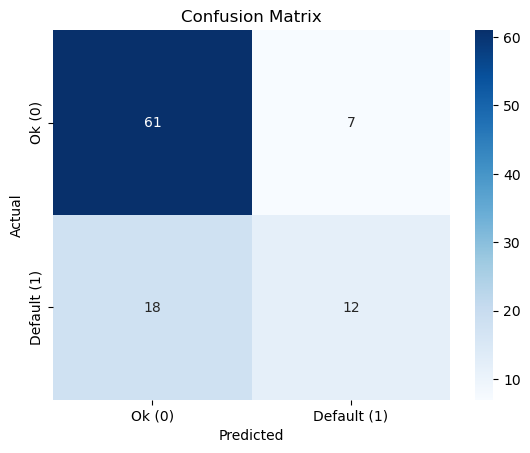

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.90      0.83        68
           1       0.63      0.40      0.49        30

    accuracy                           0.74        98
   macro avg       0.70      0.65      0.66        98
weighted avg       0.73      0.74      0.73        98



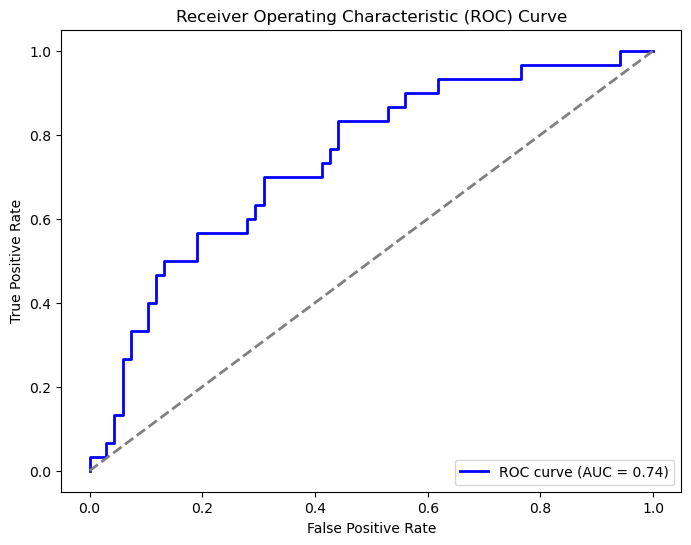

In [135]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (class 1)

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ok (0)', 'Default (1)'], yticklabels=['Ok (0)', 'Default (1)'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 2. Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 3. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

C:\Users\TYY\anaconda3\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


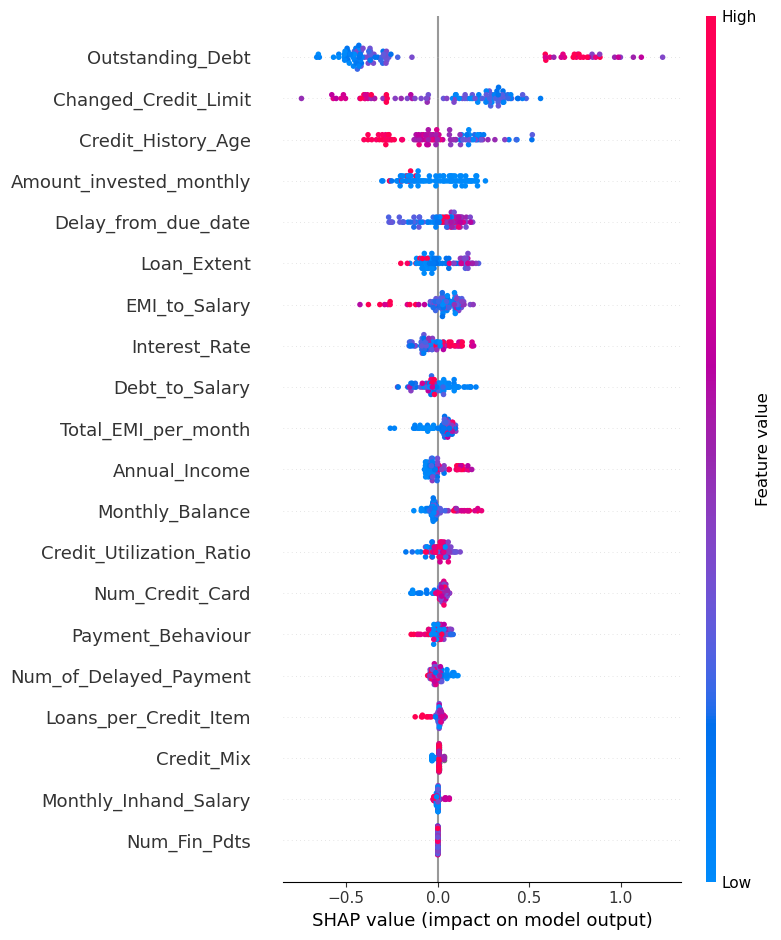

In [137]:
import shap

# Create SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test)

In [139]:
# Compute mean absolute SHAP value per feature
mean_abs_shap = np.abs(shap_values).mean(axis=0)

# Create DataFrame for sorting
shap_importance = pd.DataFrame({
    'feature': X_test.columns,
    'mean_abs_shap': mean_abs_shap
})

# Sort from least to most important
shap_importance_sorted = shap_importance.sort_values(by='mean_abs_shap', ascending=True)

# View the least important features
print(shap_importance_sorted.head(10))  # or .tail() for most important

                     feature  mean_abs_shap
2          Num_Bank_Accounts       0.000000
16              Num_Fin_Pdts       0.000000
1      Monthly_Inhand_Salary       0.009206
8                 Credit_Mix       0.012648
17     Loans_per_Credit_Item       0.017143
6     Num_of_Delayed_Payment       0.026305
14         Payment_Behaviour       0.033804
3            Num_Credit_Card       0.038873
10  Credit_Utilization_Ratio       0.039839
15           Monthly_Balance       0.053196


## Diagnostics - Export CSV

In [ ]:
# Create a DataFrame to compare actual and predicted values
results_df = X_test.copy()
results_df['actual_label'] = y_test.values
results_df['predicted_label'] = y_pred

# Investigated raw predicted probabilities (for ROC, etc.)
results_df['predicted_proba'] = model.predict_proba(X_test)[:, 1]  # Probability for class 1

# Step 3: Export to CSV
results_df.to_csv('model_predictions.csv', index=False)

print("Exported predictions to 'model_predictions.csv'")